In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import math
import random
from itertools import count
from collections import namedtuple, deque

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
filename = "EURUSD_M1_2023.csv"

df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']) 

#timestamp as index
df.set_index('timestamp', inplace=True)
data = df.resample('5min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

#Drop NA rows
data = data.dropna(axis=0)

print(data.head(10))
print(data.describe())

             timestamp     open     high      low    close
0  2023-01-01 17:05:00  1.06973  1.06978  1.06966  1.06970
1  2023-01-01 17:10:00  1.06975  1.07066  1.06899  1.06899
2  2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
7  2023-01-01 17:40:00  1.06904  1.06958  1.06904  1.06934
8  2023-01-01 17:45:00  1.06962  1.07061  1.06860  1.06894
9  2023-01-01 17:50:00  1.06944  1.07007  1.06860  1.06881
10 2023-01-01 17:55:00  1.06879  1.06954  1.06823  1.06929
11 2023-01-01 18:00:00  1.06896  1.06941  1.06863  1.06863
12 2023-01-01 18:05:00  1.06942  1.06953  1.06836  1.06836
13 2023-01-01 18:10:00  1.06916  1.07040  1.06829  1.06895
                           timestamp          open          high  \
count                          64856  64856.000000  64856.000000   
mean   2023-07-09 03:27:22.043912704      1.080766      1.080947   
min              2023-01-01 17:05:00      1.044990      1.045370   
25%              2023-04-02 21:23:45      1.068370      1.068540   
50%        

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
from envs import ForexEnv, Actions


window_size = 10
start_index = window_size
end_index = len(data)
# len(data)

env  = ForexEnv(
    df= data,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

In [39]:
from stable_baselines3 import DQN
import torch.optim as optim

learning_rate = 0.01
optimizer = optim.Adam

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=learning_rate,
    verbose=1,
    device=device,
)
model.learn(total_timesteps=1000, log_interval=4)
# model.save("dqn_stable_baseline3_eurusd_2023_5M")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_stable_baseline3_eurusd_2023_5M")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [45]:

#initial state
action_stats = {Actions.Sell: 0, Actions.Buy: 0,}

observation, info = env.reset()

while True:
    action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)
print("Trades:", env.unwrapped)


action_stats: {<Actions.Sell: 0>: 63209, <Actions.Buy: 1>: 1636}
info: {'total_reward': -486.48834228515625, 'total_profit': 0.6184620065245494, 'position': <Positions.Short: 0>}
Trades: <ForexEnv instance>


In [41]:
model.save("dqn_stable_baseline3_eurusd_2023_5M")

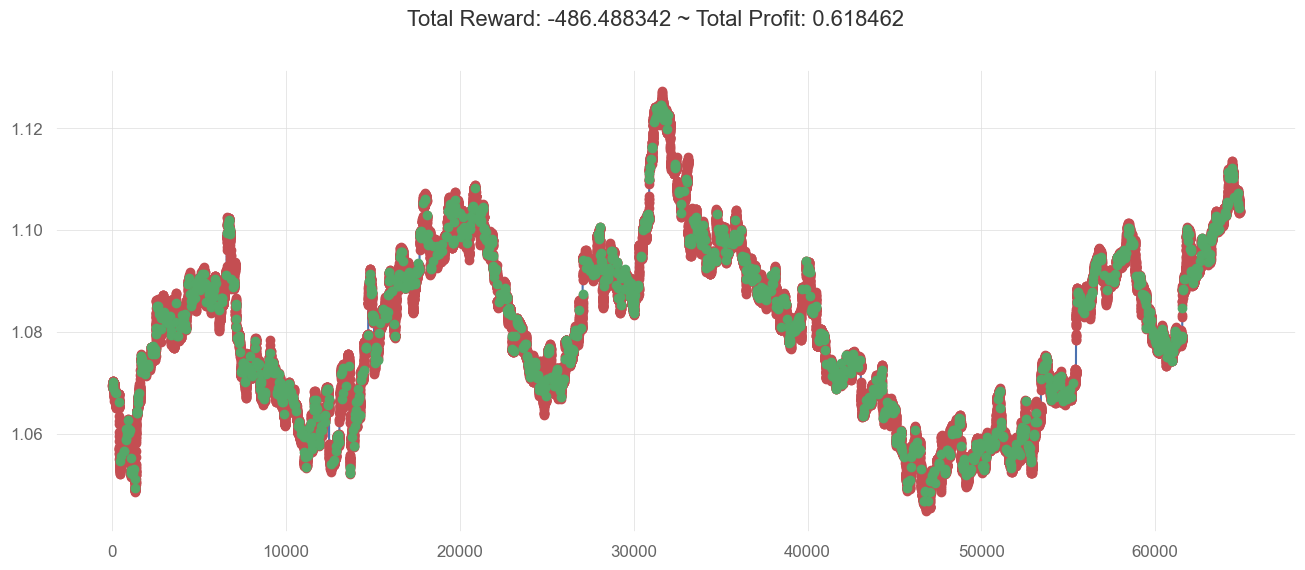

In [46]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

timestamp
2023-01-01 17:45:00    0.000000
2023-01-01 17:46:00    0.000000
2023-01-01 17:47:00    0.000000
2023-01-01 17:48:00    0.000000
2023-01-01 17:49:00    0.000000
                         ...   
2023-03-10 04:57:00    0.000000
2023-03-10 04:58:00    0.000000
2023-03-10 04:59:00    0.000000
2023-03-10 05:00:00    0.000000
2023-03-10 05:01:00   -0.000408
Length: 64844, dtype: float64


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

                           Strategy
-------------------------  ----------
Start Period               2023-01-01
End Period                 2023-03-10
Risk-Free Rate             0.0%
Time in Market             3.0%

Cumulative Return          -37.64%
CAGR﹪                     -83.07%

Sharpe                     -0.38
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -0.38
Sortino                    -0.51
Smart Sortino              -0.51
Sortino/√2                 -0.36
Smart Sortino/√2           -0.36
Omega                      0.6

Max Drawdown               -38.47%
Longest DD Days            68
Volatility (ann.)          0.48%
Calmar                     -2.16
Skew                       2.78
Kurtosis                   684.2

Expected Daily %           -0.0%
Expected Monthly %         -14.56%
Expected Yearly %          -37.64%
Kelly Criterion            -22.08%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.05%
Expected Shortfall (cVaR)  -0.05%

Max Consecutive W

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-01-02,2023-03-09,2023-03-10,68,-38.469977,-37.929144
2,2023-01-01,2023-01-02,2023-01-02,1,-0.270666,-0.268798
3,2023-01-01,2023-01-01,2023-01-01,1,-0.173897,-0.163616
4,2023-01-02,2023-01-02,2023-01-02,1,-0.058733,NaN


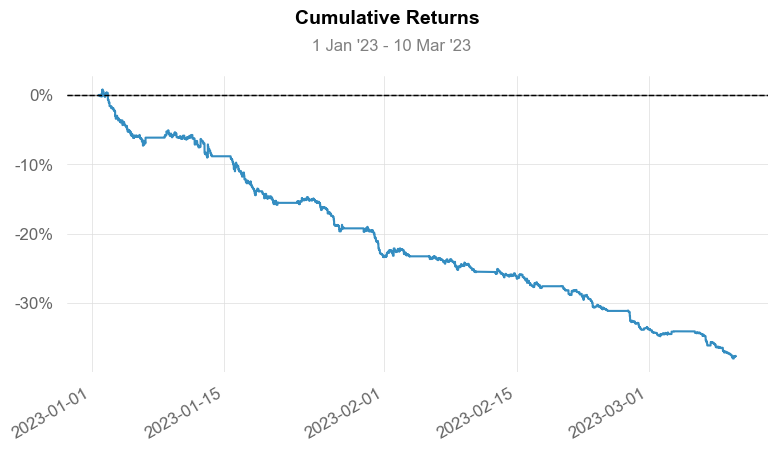

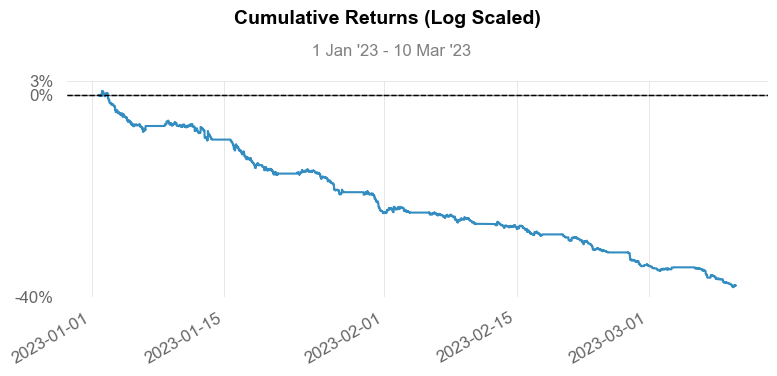

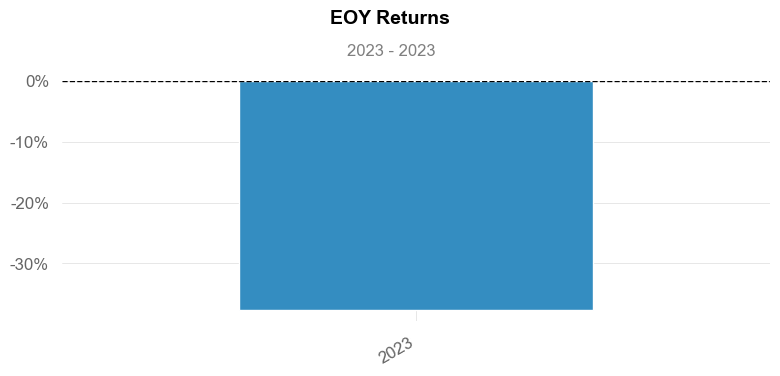

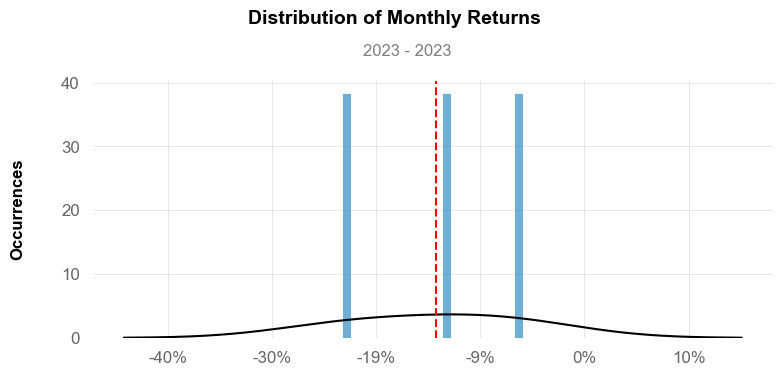

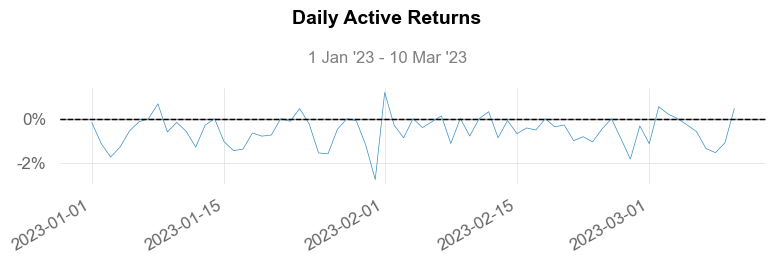

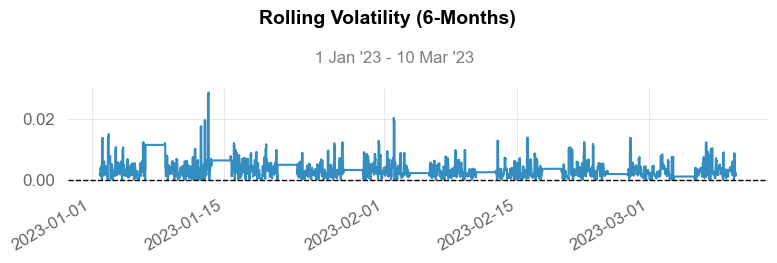

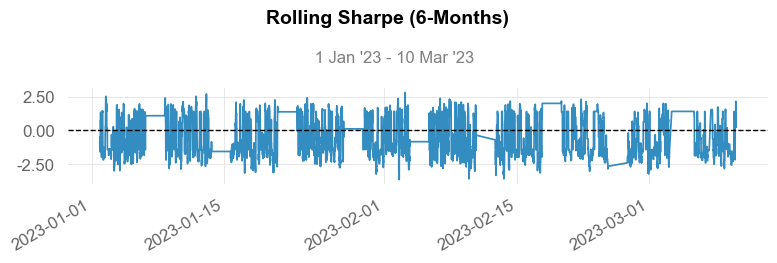

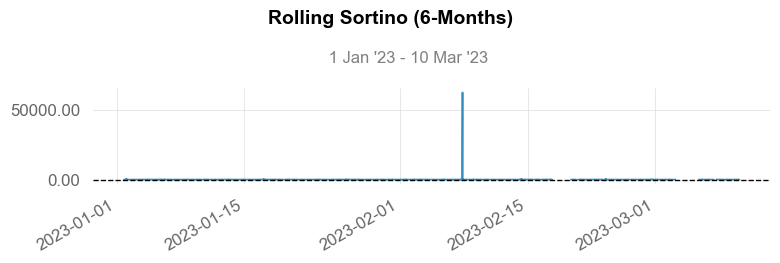

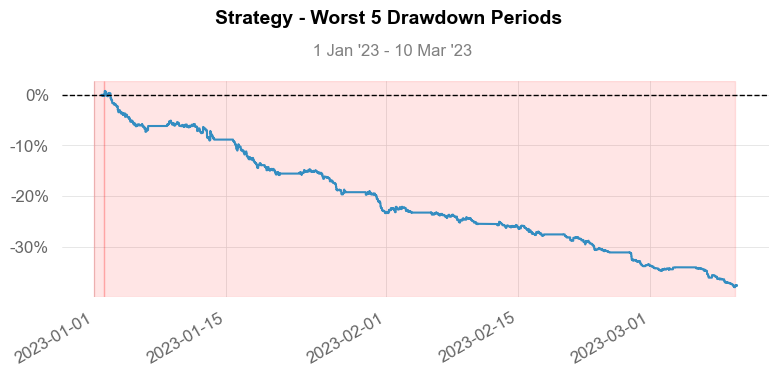

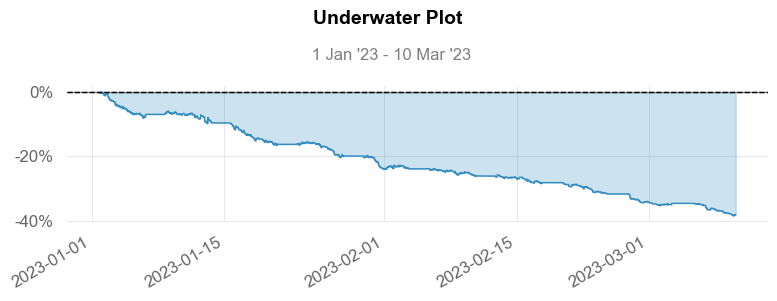

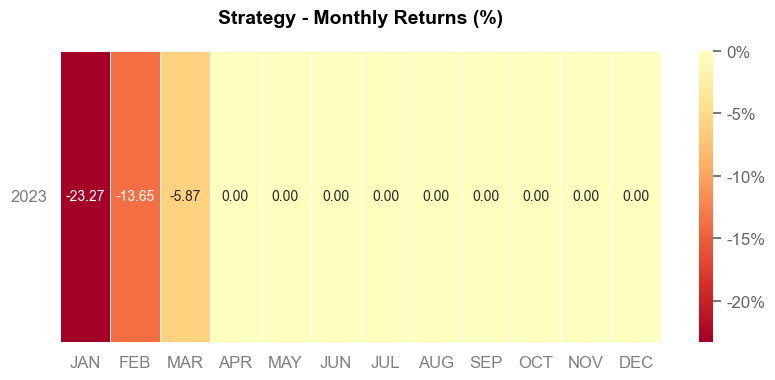

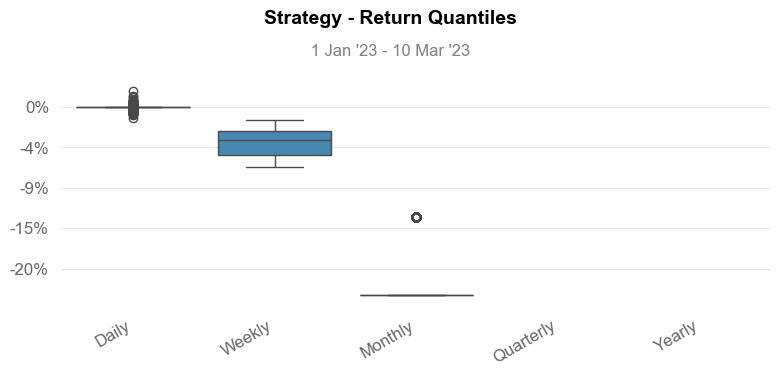

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

In [44]:
import quantstats as qs

qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns)

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')